In [1]:
# bootstrap standard error
# create a file

In [2]:
# %load_ext autoreload
# %autoreload 2
# %load_ext line_profiler
# %alias_magic t timeit
# %load_ext memory_profiler

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [3]:
import os, sys
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [5]:
import jax
# jax.config.update('jax_platform_name', 'cpu')

In [6]:

jax.devices()

2023-03-31 19:28:55.918707: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-03-31 19:28:55.918811: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.85.12 does not match DSO version 525.105.17 -- cannot find working devices in this configuration


[CpuDevice(id=0)]

In [7]:
import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np


from momi3.Params import Params
from momi3.MOMI import Momi

import re
import math

from tqdm.notebook import tqdm

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp
import jax
#jax.config.update('jax_platform_name', 'cpu')

In [8]:
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

In [9]:
# Load demes graph
demo = demes.load(f"8_pop_3_admix.yaml")

In [10]:
sampled_demes = demo.metadata['sampled_demes']
sample_sizes = demo.metadata['sample_sizes']

In [11]:
# Construct momi
momi = Momi(
    demo, sampled_demes=sampled_demes, sample_sizes=sample_sizes, jitted=True, low_memory=False
)

In [12]:
jsfs = momi.simulate(10000, seed=108)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
momi.batch_size = jsfs.nnz + 3

In [43]:
params = Params(momi)
params.set_train_all_pis(True)
params.set_train('eta_11', True)
params.set_train('eta_6', True)
params.set_train('eta_5', True)
params.set_train('eta_4', True)
params.set_train('eta_15', True)
params.set_train('tau_7', True)
params.set_train('tau_3', True)
params.set_train('tau_2', True)

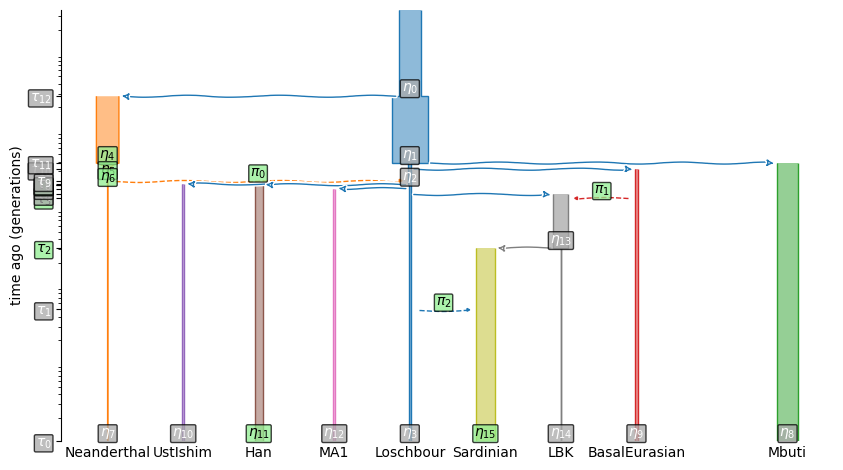

In [44]:
params.tubes(False, True, log_time=True)

In [45]:
theta_train_dict = params.theta_train_dict(transformed=True)

In [46]:
theta_train_dict

{'log(eta_4)': 9.809176873064887,
 'log(eta_5)': 9.809176873064887,
 'log(eta_6)': 4.464758032271346,
 'log(eta_11)': 8.748304912379623,
 'log(eta_15)': 9.615805480084347,
 'logit(pi_0)': -3.4899339962998255,
 'logit(pi_1)': -2.2704503262302502,
 'logit(pi_2)': -3.4192252757342505,
 'log(tau_2-tau_1)': 5.554508771908447,
 'log(tau_3-tau_2)': 6.947360533574496,
 'log(tau_4-tau_3)': 5.075173815233827,
 'log(tau_7-tau_6)': 2.772588722239781,
 'log(tau_8-tau_7)': 3.784189633918261}

In [47]:
from LOO_optimization import LOO_optimization

# Profile likelihood CI

In [48]:
# How to use
ret = LOO_optimization(
    momi, params, jsfs,
    transformed=True,
    initial_tr_radius=0.5,
    verbose=2, # print each epoch
    maxiter=50 # increase the number of iterations
)

MLE_hat = -ret.fun

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.0118e+04 | 5.00e-01 | 1.05e+02 | 0.00e+00 |
|   2   |   2   |   1   | +1.0070e+04 | 1.00e+00 | 4.92e+01 | 0.00e+00 |
|   3   |   3   |   3   | +1.0027e+04 | 5.46e+00 | 2.26e+01 | 0.00e+00 |
|   4   |   4   |   6   | +1.0020e+04 | 5.46e+00 | 2.27e+01 | 0.00e+00 |
|   5   |   5   |   9   | +1.0018e+04 | 5.46e+00 | 1.01e+01 | 0.00e+00 |
|   6   |   6   |  12   | +1.0017e+04 | 5.46e+00 | 8.43e+00 | 0.00e+00 |
|   7   |   7   |  16   | +1.0015e+04 | 5.46e+00 | 7.79e+00 | 0.00e+00 |
|   8   |   8   |  20   | +1.0014e+04 | 5.46e+00 | 8.01e+00 | 0.00e+00 |
|   9   |   9   |  24   | +1.0012e+04 | 5.46e+00 | 5.66e+00 | 0.00e+00 |
|  10   |  10   |  28   | +1.0011e+04 | 5.46e+00 | 5.45e+00 | 0.00e+00 |
|  11   |  11   |  33   | +1.0010e+04 | 5.46e+00 | 5.43e+00 | 0.00e+00 |
|  12   |  12   |  38   | +1.0009e+04 | 5.46e+00 | 

In [49]:
myrange = np.linspace(3000, 12000, 5) # Increase the grid size

lls = []
for value in tqdm(myrange):
    ll = []
    for lr in [0.5, 0.05, 0.005]:
        ret = LOO_optimization(
            momi, params, jsfs,
            out_key='eta_11',
            out_value=value,
            transformed=True,
            initial_tr_radius=lr,
            verbose=0,
            maxiter=2 # increase this
        )
        ll.append(-ret.fun)
    lls.append(max(ll))

  0%|          | 0/5 [00:00<?, ?it/s]

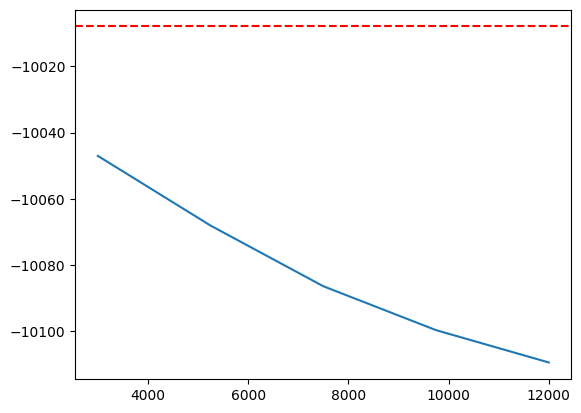

In [50]:
plt.plot(myrange, lls)
plt.axhline(MLE_hat - 2, linestyle='--', color='red')

# Bootstrap CI

In [36]:
# First get the bootstraped jsfs with random seed 108
bs_jsfs = momi._bootstrap_sample(jsfs, seed=108)

# do below bunch of times and see the variation in eta_11 hat

ret = LOO_optimization(
    momi, params, bs_jsfs,
    transformed=True,
    initial_tr_radius=0.01,
    verbose=2,
    maxiter=50
)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.0183e+04 | 1.00e-02 | 1.25e+02 | 0.00e+00 |
|   2   |   2   |   1   | +1.0182e+04 | 7.00e-02 | 1.21e+02 | 0.00e+00 |
|   3   |   3   |   2   | +1.0172e+04 | 4.90e-01 | 1.01e+02 | 0.00e+00 |
|   4   |   4   |   4   | +1.0132e+04 | 3.43e+00 | 3.53e+01 | 0.00e+00 |
|   5   |   5   |   6   | +1.0116e+04 | 3.43e+00 | 1.83e+01 | 0.00e+00 |
|   6   |   6   |   9   | +1.0109e+04 | 3.43e+00 | 1.01e+01 | 0.00e+00 |
|   7   |   7   |  12   | +1.0108e+04 | 3.43e+00 | 8.02e+00 | 0.00e+00 |
|   8   |   8   |  15   | +1.0107e+04 | 3.43e+00 | 6.85e+00 | 0.00e+00 |
|   9   |   9   |  19   | +1.0107e+04 | 3.43e+00 | 5.30e+00 | 0.00e+00 |
|  10   |  10   |  23   | +1.0106e+04 | 3.43e+00 | 5.89e+00 | 0.00e+00 |
|  11   |  11   |  27   | +1.0104e+04 | 3.48e+00 | 7.19e+00 | 0.00e+00 |
|  12   |  12   |  31   | +1.0100e+04 | 6.96e+00 | 

KeyboardInterrupt: 

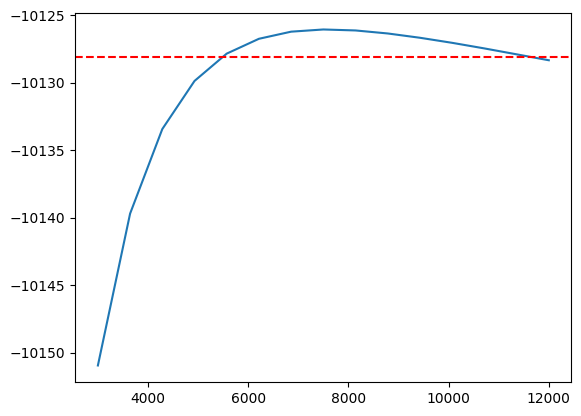

In [63]:
plt.plot(myrange, lls)
plt.axhline(MLE_hat - 2, linestyle='--', color='red')

# profile likelihood example

In [46]:
# Normal


In [163]:
def gen_sym_cov_matrix(p, corr):
    Sigma = np.ones((p, p)) * corr
    Sigma += np.diag(p * [1 - corr])
    return Sigma

In [164]:
def model(b, X):
    return X @ b

In [165]:
n = 100
p = 10
corr = 0.8

b = np.random.randn(p)

np.random.seed(108)

X = stats.multivariate_normal(mean=p * [0], cov=gen_sym_cov_matrix(p, corr)).rvs(n)
eps = stats.norm(0, np.sqrt(p)*0.4).rvs(n)
y = model(b, X) + eps

In [166]:
@jax.jit
def loglik(b, X, y):
    yhat = model(b, X)
    return jnp.sum(jnp.power(y - yhat, 2))

jvag = jax.value_and_grad(loglik)

def f(b, X, y, out=None):
    v, g = jvag(b, X, y)
    if out is None:
        pass
    else:
        g = g.at[out].set(0.)
    return v, g

fun = lambda b: f(b, X, y, out=0)

In [167]:
def get_mle(b, out_index=None, out_val=None):
    b = b.copy()
    b1 = out_index is None
    b2 = out_val is None
    
    if b1 and b2:
        # General MLE
        fun = lambda b: f(b, X, y)
    elif not b1 and not b2:
        b[out_index] = out_val
        fun = lambda b: f(b, X, y, out=out_index)
    else:
        raise ValueError("Wrong Config")
        
    opt_res = optimize.minimize(fun, jac=True, x0=b, method='SLSQP')    
    return opt_res

In [168]:
mle_res = get_mle(b)

mle_loglik = -mle_res.fun
b_hat = mle_res.x

b_hat0 = b_hat[0]

In [20]:
H = jax.hessian(loglik)(b_hat, X, y)
std_error = np.sqrt(np.diag(np.linalg.pinv(H)))
std0 = std_error[0]
rv = stats.norm(loc=b_hat0, scale=std0)

In [21]:
xlim = [b_hat0 - 3*std0, b_hat0 + 3*std0]
b_0s = np.linspace(xlim[0], xlim[1], 50)

logliks = np.array([-get_mle(b, 0, b_0).fun for b_0 in b_0s])

In [22]:
myhline = mle_loglik - 2

In [23]:
sorted_ind = np.argsort(np.abs(logliks - myhline))
v1 = sorted_ind[0]
for i, val in enumerate(sorted_ind[1:]):
    if abs(v1 - val) == (i + 1):
        pass
    else:
        v2 = val
        break

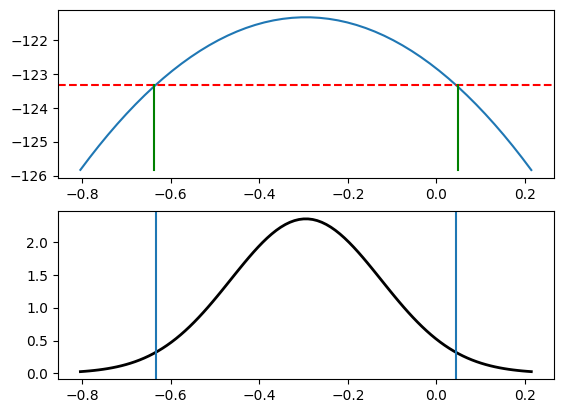

In [24]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(b_0s, logliks)
axs[0].axhline(myhline, color='red', linestyle='dashed')
axs[0].plot([b_0s[v1], b_0s[v1]], [myhline, min(logliks)], color = 'green')
axs[0].plot([b_0s[v2], b_0s[v2]], [myhline, min(logliks)], color = 'green')

x = np.linspace(xlim[0], xlim[1], 100)
axs[1].plot(x, rv.pdf(x), 'k-', lw=2)
axs[1].axvline(b_hat0 - 2*std0)
axs[1].axvline(b_hat0 + 2*std0)